# EDA for IEEE-CIS Fraud Detection
Detect fraud from customer transactions.

https://www.kaggle.com/competitions/ieee-fraud-detection/data


[Data Description (Details and Discussion)](https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/101203)

### **Transaction Table**
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

### **Identity Table**  

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

> ### features informs
- TransacionDT  
    - **value** / (60 X 60 X 24) = **'DAY'**
- dist          
    - 청구주소, 우편주소, 등 지역간 거리
- D columns     
    - **TransactionDT**와 연산되는 시간 데이터.
        - D1        : Day - D1 = 카드 사용 시작일
        - D3        : Day - D3 = 최근 거래일
        - D9        : D9  * 24 = 거래 시간 (0 ~ 23)
        - ....
- M columns
    - True or False
- id_14
    - [-720 : 720 : 30] : timezone

> ### Reduced features
* Transation
    - P_emaildomain (59개) → 7개, R_emaildomain (60개) → 7개
        * [gmail, yahoo, outlook, anonymous, aol, icloud, other]
* identity
    - id_30 (75개) → 6개
        * [Windows, iOS, Android, Linux, Mac, other]
    - id_31 (130개) → 8개
        * [chrome, safari, firefox, edge, samsung, ie, opera,other]
    - DeviceInfo (1786개) → 20개
        * [SAMSUNG, MOTO, LG, HUAWEI, SONY, ALCATEL, BLADE, HTC, LENOVO, ILIUM, PIXEL, HISENSE, M4, REDMI, ZTE, NOKIA, LINUX, NEXUS, Android, Other]

> ### Droped columns
- #### Transaction
    - ['dist1', 'dist2']
    - ['C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14',]
        - ['C1', 'C9] 만 사용
> - ['R_emaildomain', 'P_emaildomain']
> - ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8']
> - ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
> - ['addr1', 'addr2']
> - ['ProductCD']
    >> - <u>**User 특정화 ['uid'] 새로운 column으로 통합**</u>

- #### Identity
    - ['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_33']
        - 결측치 99% 이상

In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyparsing import line
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [328]:
train_t= pd.read_csv('../data/train_transaction.csv',index_col='TransactionID')
train_i = pd.read_csv('../data/train_identity.csv',index_col='TransactionID')

test_t= pd.read_csv('../data/test_transaction.csv',index_col='TransactionID')
test_i = pd.read_csv('../data/test_identity.csv',index_col='TransactionID')
submission = pd.read_csv('../data/sample_submission.csv',index_col='TransactionID')

train_m = pd.merge(train_t, train_i, how='left', on='TransactionID')
test_m = pd.merge(test_t, test_i, how='left', on='TransactionID')

In [329]:
# def

# dataframe color
def draw_color_over(x, color):
    if (x >= find_num or x <= (-find_num)) & (x != 1):
        color = f'background-color:{color}'
        return color
    else:
        return ''

def draw_color_under(x, color):
    if (x <= find_num) & (x != 1):
        color = f'background-color:{color}'
        return color
    else:
        return ''
        
# reduce feature
def classreduce(df_train):

    # id_30 
    df_train['id_30'][df_train['id_30'].str.contains('Window') == True] = 'Windows'
    df_train['id_30'][df_train['id_30'].str.contains('Android') == True] = 'Android'
    df_train['id_30'][df_train['id_30'].str.contains('iOS') == True] = 'iOS'
    df_train['id_30'][df_train['id_30'].str.contains('Mac') == True] = 'Mac'
    df_train['id_30'][df_train['id_30'].str.contains('Linux') == True] = 'Linux'
    df_train.loc[~df_train['id_30'].isin(['Windows',
                                        'Android',
                                        'iOS',
                                        'Mac',
                                        'Linux',
                                        ]),'id_30'] = 'Other'


    # id_31
    df_train['id_31'][df_train['id_31'].str.contains('chrome') == True] = 'chrome'
    df_train['id_31'][df_train['id_31'].str.contains('safari') == True] = 'safari'
    df_train['id_31'][df_train['id_31'].str.contains('firefox') == True] = 'firefox'
    df_train['id_31'][df_train['id_31'].str.contains('edge') == True] = 'edge'
    df_train['id_31'][df_train['id_31'].str.contains('samsung') == True] = 'samsung'
    df_train['id_31'][df_train['id_31'].str.contains('ie') == True] = 'ie'
    df_train['id_31'][df_train['id_31'].str.contains('opera') == True] = 'opera'
    df_train.loc[~df_train['id_31'].isin(['chrome',
                                        'safari',
                                        'firefox',
                                        'edge',
                                        'samsung',
                                        'ie',
                                        'opera',
                                        ]),'id_31'] = 'other'


    # DeviceInfo
    df_train['DeviceInfo'] = df_train['DeviceInfo'].str.lower()

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('alcatel') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('4013') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('4047') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('501') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('5020') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('5025') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('5049') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('5054') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('5056') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('5080') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('5085') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('5049w') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('9003a') == True] = 'ALCATEL'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('9008a') == True] = 'ALCATEL'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('android') == True] = 'Android'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('blade') == True] = 'BLADE'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('hisense') == True] = 'HISENSE'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('htc') == True] = 'HTC'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('huawei') == True] = 'HUAWEI'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('/huawei') == True] = 'HUAWEI'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('hi6210sft') == True] = 'HUAWEI'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('ilium') == True] = 'ILIUM'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('ios device') == True] = 'iOS'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('lenovo') == True] = 'LENOVO'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('mot-') == True] = 'LENOVO'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('lg') == True] = 'LG'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('lg-') == True] = 'LG'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('vs') == True] = 'LG'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('linux') == True] = 'LINUX'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('macos') == True] = 'Mac OS'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('moto') == True] = 'MOTO'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('mot') == True] = 'MOTO'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('xt') == True] = 'MOTO'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('m4') == True] = 'M4'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('nexus') == True] = 'NEXUS'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('ta-') == True] = 'NOKIA'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('nokia') == True] = 'NOKIA'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('pixel') == True] = 'PIXEL'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('redmi') == True] = 'REDMI'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('rv:') == True] = 'rv:'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('samsung') == True] = 'SAMSUNG'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('sm-') == True] = 'SAMSUNG'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('gt-') == True] = 'SAMSUNG'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('gxq6580_weg_l') == True] = 'SAMSUNG'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('sgh-') == True] = 'SAMSUNG'
        
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('c6906') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('d5316') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('d5803') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('d6603') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('g8141') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('f8331') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('sov33') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('e2') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('e5') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('e6') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('f3') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('f5') == True] = 'SONY'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('g3') == True] = 'SONY'    
        
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('windows') == True] = 'Windows'

    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('z8') == True] = 'ZTE'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('z9') == True] = 'ZTE'
    df_train['DeviceInfo'][df_train['DeviceInfo'].str.contains('zte') == True] = 'ZTE'   
        
    df_train.loc[~df_train['DeviceInfo'].isin([
                                            'Windows',
                                            'iOS',
                                            'Mac OS',
                                            'SAMSUNG',
                                            'MOTO',
                                            'LG',
                                            'HUAWEI',
                                            'SONY',
                                            'ALCATEL',
                                            'BLADE',
                                            'HTC',
                                            'LENOVO',
                                            'ILIUM',
                                            'PIXEL',
                                            'HISENSE',
                                            'M4',
                                            'REDMI',
                                            'ZTE',                               
                                            'NOKIA',
                                            'LINUX',
                                            'NEXUS',
                                            'Android',
                                        ]),'DeviceInfo'] = 'Other'


    # P_emaildomain
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('gmail') == True] = 'gmail'
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('yahoo') == True] = 'yahoo'
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('outlook') == True] = 'outlook'
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('hotmail') == True] = 'outlook'
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('msn') == True] = 'outlook'
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('live') == True] = 'outlook'
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('anonymous') == True] = 'anonymous'
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('aol') == True] = 'aol'
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('icloud') == True] = 'icloud'
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('mac') == True] = 'icloud'
    df_train['P_emaildomain'][df_train['P_emaildomain'].str.contains('me') == True] = 'icloud'
    df_train.loc[~df_train['P_emaildomain'].isin([
                                        'gmail',
                                        'yahoo',
                                        'outlook',
                                        'anonymous',
                                        'aol',
                                        'icloud',
                                        ]),'P_emaildomain'] = 'other'


    # R_emaildomain
    df_train.R_emaildomain.loc[df_train.R_emaildomain.str.contains('gmail') == True] = 'gmail'
    df_train['R_emaildomain'][df_train['R_emaildomain'].str.contains('yahoo') == True] = 'yahoo'
    df_train['R_emaildomain'][df_train['R_emaildomain'].str.contains('outlook') == True] = 'outlook'
    df_train['R_emaildomain'][df_train['R_emaildomain'].str.contains('hotmail') == True] = 'outlook'
    df_train['R_emaildomain'][df_train['R_emaildomain'].str.contains('msn') == True] = 'outlook'
    df_train['R_emaildomain'][df_train['R_emaildomain'].str.contains('live') == True] = 'outlook'
    df_train['R_emaildomain'][df_train['R_emaildomain'].str.contains('anonymous') == True] = 'anonymous'
    df_train['R_emaildomain'][df_train['R_emaildomain'].str.contains('aol') == True] = 'aol'
    df_train['R_emaildomain'][df_train['R_emaildomain'].str.contains('icloud') == True] = 'icloud'
    df_train['R_emaildomain'][df_train['R_emaildomain'].str.contains('mac') == True] = 'icloud'
    df_train['R_emaildomain'][df_train['R_emaildomain'].str.contains('me.') == True] = 'icloud'
    df_train.loc[~df_train['R_emaildomain'].isin([
                                        'gmail',
                                        'yahoo',
                                        'anonymous',
                                        'aol',
                                        'outlook',
                                        'icloud',
                                        ]),'R_emaildomain'] = 'other'

    return df_train

# str grouping
def group_str(col):
    return train_t.loc[:,list(train_t.columns[train_t.columns.str.contains(col)])]

# nan_count
nancount = list(group_str('V').isnull().sum().value_counts().index)
# nan_values groups , len = 15
def nan_group(n):
    return list(group_str('V').isnull().sum()[group_str('V').isnull().sum().values==nancount[n]].index)

# uid
def uid(df):
    df['D1_shift'] = (df['D1'] - df.TransactionDT // 24 // 3600).fillna(-400)
    df['uid'] = df['D1_shift'].astype(str)+'_'+df['card1'].astype(str)+'_'+df['P_emaildomain'].astype(str)+df['addr1'].astype(str) +'_'+df['ProductCD'].astype(str)
    return df

# nan value check
def top_missing_cols(df,n=10,thresh=80):
  
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff


### Transaction Table

#### TransactionDT

[]

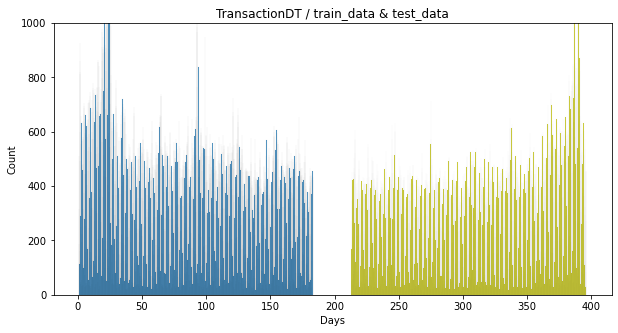

In [6]:
plt.figure(figsize=(10,5))
plt.title('TransactionDT / train_data & test_data')
plt.xlabel('Days')

sns.histplot(train_t['TransactionDT'] / (3600*24), bins=1800).set(ylim=(0,1000))

sns.histplot(test_t['TransactionDT'] / (3600*24), bins=1800,color='y').set()

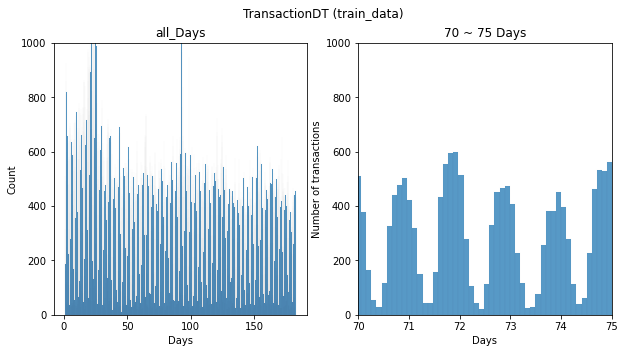

In [45]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.suptitle('TransactionDT (train_data)')

sns.histplot(train_t['TransactionDT'] / (3600*24), bins=1800, ax=axes[0]).set(ylim=(0,1000),title='all_Days',xlabel='Days')
plt.xlabel('Days')
plt.ylabel('Number of transactions')


sns.histplot(train_t['TransactionDT'] / (3600*24), bins=1800, ax=axes[1]).set(xlim=(70, 75), ylim=(0, 1000), xlabel='Days', title='70 ~ 75 Days')

plt.show()

#### TransactionAmt

[(0.0, 400.0)]

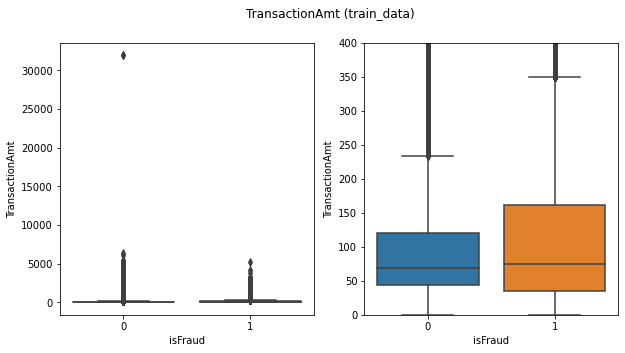

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
plt.suptitle('TransactionAmt (train_data)')

sns.boxplot(data=train_t, x='isFraud', y='TransactionAmt',ax=axes[0]).set()
sns.boxplot(data=train_t, x='isFraud', y='TransactionAmt',ax=axes[1]).set(ylim=(0,400))

#### ProductCD

Text(0, 0.5, 'Fraud %')

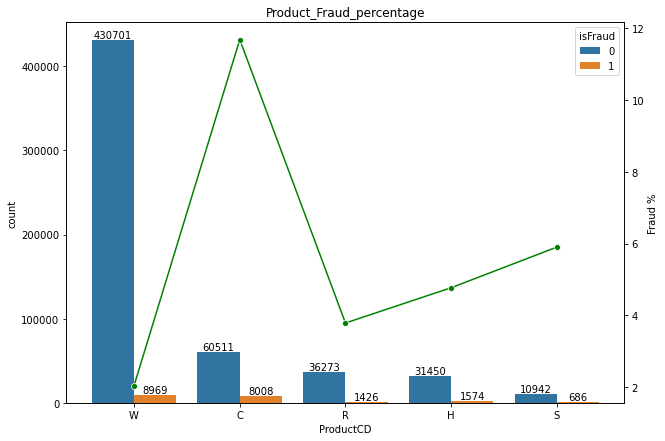

In [9]:
pf=train_t.ProductCD[train_t.isFraud==1]

fig, ax = plt.subplots(1,figsize=(10,7))
plt.title('Product_Fraud_percentage')

sns.countplot(data=train_t, x='ProductCD',hue='isFraud',
            ax=ax,
            order=list(train_t.ProductCD.value_counts().index),
            )
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

sns.lineplot(x=pf.value_counts().index,
             y=pf.value_counts().reindex(index=list(train_t.ProductCD.value_counts().index)) / train_t.ProductCD.value_counts().reindex(index=list(train_t.ProductCD.value_counts().index))*100,
             ax=ax.twinx(),
             color='g',
             marker="o",
             ).set_ylabel('Fraud %')

#### card1 ~ card6

In [10]:
group_str('card').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   card1   590540 non-null  int64  
 1   card2   581607 non-null  float64
 2   card3   588975 non-null  float64
 3   card4   588963 non-null  object 
 4   card5   586281 non-null  float64
 5   card6   588969 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 27.0+ MB


##### card4

Text(0, 0.5, 'Fraud_*')

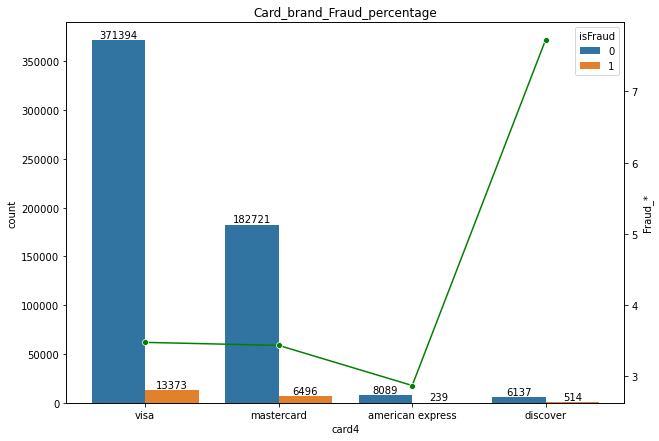

In [11]:
pcf=train_t.card4[train_t.isFraud==1]

fig, ax = plt.subplots(1,figsize=(10,7))
plt.title('Card_brand_Fraud_percentage')

sns.countplot(data=train_t, x='card4',hue='isFraud',
            ax=ax,
            order=list(train_t.card4.value_counts().index),
            )
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

sns.lineplot(x=pcf.value_counts().index,
             y=pcf.value_counts().reindex(index=list(train_t.card4.value_counts().index)) / train_t.card4.value_counts().reindex(index=list(train_t.card4.value_counts().index))*100,
             ax=ax.twinx(),
             color='g',
             marker="o",
             ).set_ylabel('Fraud_*')

##### card6

Text(0, 0.5, 'Fraud_percent')

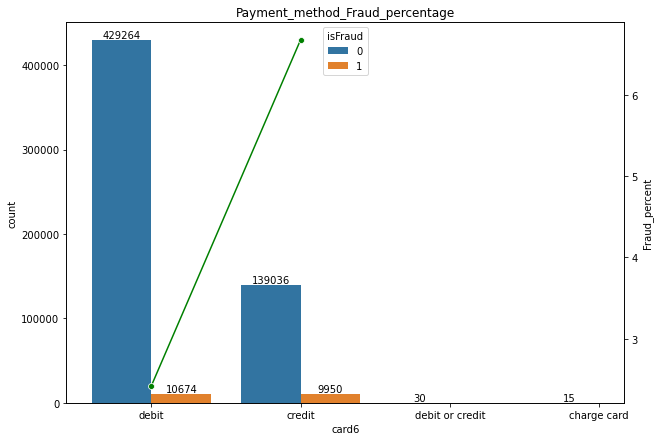

In [12]:
pcs=train_t.card6[train_t.isFraud==1]

fig, ax = plt.subplots(1,figsize=(10,7))
plt.title('Payment_method_Fraud_percentage')

sns.countplot(data=train_t, x='card6',hue='isFraud',
            ax=ax,
            order=list(train_t.card6.value_counts().index),
            )
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

sns.lineplot(x=pcs.value_counts().index,
             y=pcs.value_counts().reindex(index=['debit', 'credit']) / train_t.card6.value_counts().reindex(index=['debit', 'credit', 'debit or credit', 'charge card'])[0:2]*100, ax=ax.twinx(),
             color='g',
             marker="o",
             ).set_ylabel('Fraud_percent')

In [13]:
mdata = classreduce(train_m)

/var/folders/80/27hpx_054dl1_m05qm2q2zqr0000gn/T/ipykernel_1404/2539392478.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['id_30'][df_train['id_30'].str.contains('Window') == True] = 'Windows'
/var/folders/80/27hpx_054dl1_m05qm2q2zqr0000gn/T/ipykernel_1404/2539392478.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['id_30'][df_train['id_30'].str.contains('Android') == True] = 'Android'
/var/folders/80/27hpx_054dl1_m05qm2q2zqr0000gn/T/ipykernel_1404/2539392478.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

##### Emaildomains

Text(0, 0.5, 'Fraud_percent')

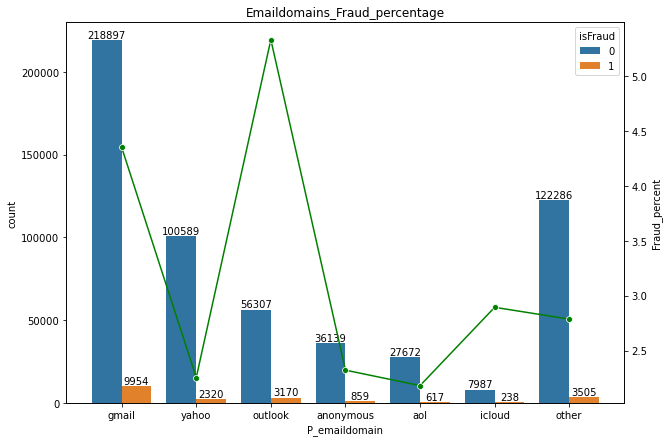

In [14]:
pce=mdata.P_emaildomain[mdata.isFraud==1]

fig, ax = plt.subplots(1,figsize=(10,7))
plt.title('Emaildomains_Fraud_percentage')

sns.countplot(data=mdata, x='P_emaildomain',hue='isFraud',
            ax=ax,
            order=['gmail', 'yahoo', 'outlook', 'anonymous', 'aol', 'icloud','other'],
            )
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

sns.lineplot(x=pce.value_counts().index,
             y=pce.value_counts(sort=True).reindex(index=['gmail', 'yahoo', 'outlook', 'anonymous', 'aol', 'icloud','other']) / mdata.P_emaildomain.value_counts(sort=True).reindex(index=['gmail', 'yahoo', 'outlook', 'anonymous', 'aol', 'icloud','other']) * 100,
             ax=ax.twinx(),
             color='g',
             marker="o",
             ).set_ylabel('Fraud_percent')

##### C columns
- 상관계수 확인
    - C1, C3, C9
- C3의 data 확인
- **최종 선별**, **이상치 제거**
    - C1, C9

In [15]:
cl = list(train_t.columns[train_t.columns.str.contains('C')==True].values)
cl.pop(0)
cl.append('isFraud')

tc = train_t.loc[:,cl]

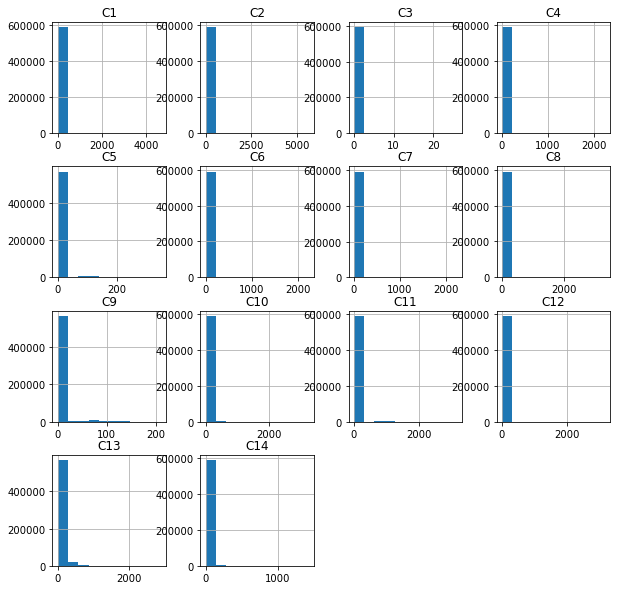

In [16]:
tc.iloc[:,0:-1].hist(figsize=(10,10))
plt.show()

<AxesSubplot:>

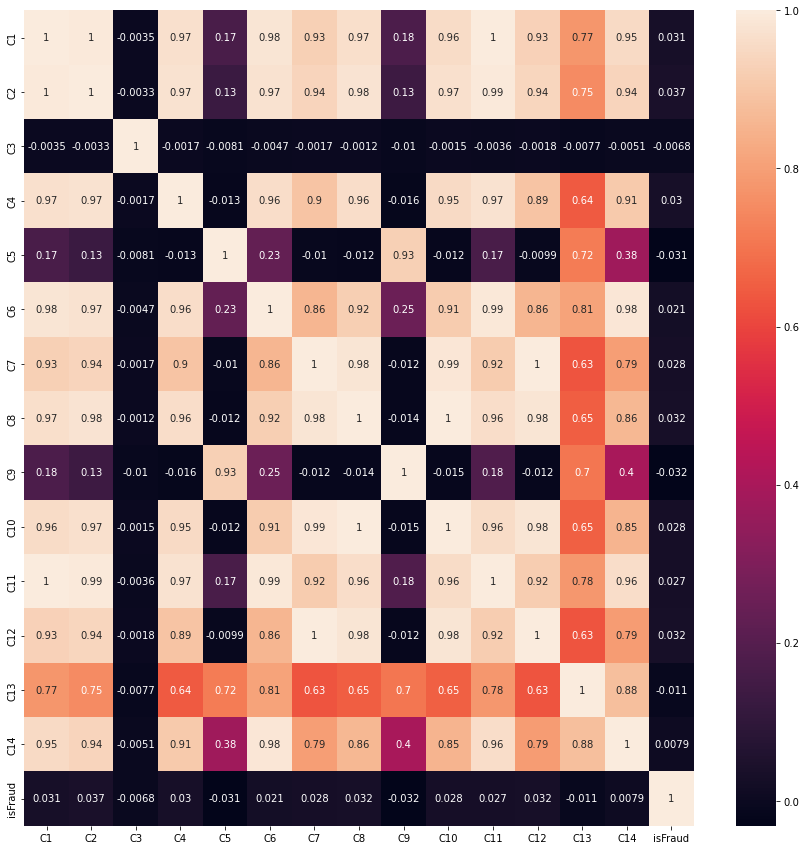

In [17]:
# 상관계수 확인
plt.figure(figsize=(15,15))
sns.heatmap(tc.corr(),annot=True)

/Users/krc/miniforge3/envs/krc2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-5.0, 5.0)

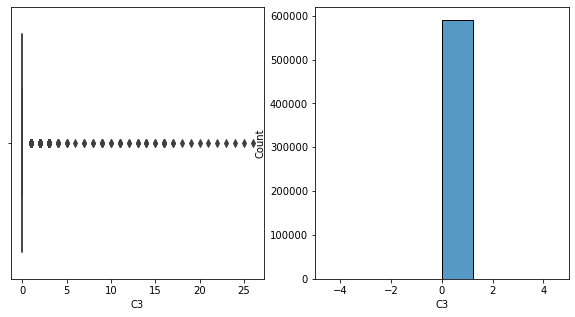

In [18]:
# C3 확인
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(tc.C3, ax=axes[0])
sns.histplot(tc.C3).set_xlim(-5,5)

In [19]:
# 이상치 처리 후 C1, C9
fenc1 = tc['C1'].quantile(.75) + (3 * (tc['C1'].quantile(.75) - tc['C1'].quantile(.25)))
fenc2 = tc['C9'].quantile(.75) + (3 * (tc['C9'].quantile(.75) - tc['C9'].quantile(.25)))
tc.drop(tc['C1'][tc['C1']>fenc1].index, inplace=True)
tc.drop(tc['C9'][tc['C9']>fenc2].index, inplace=True)

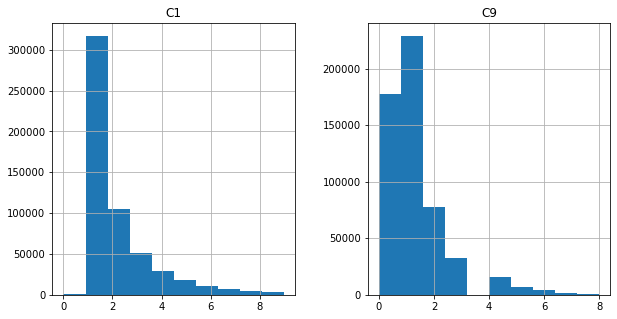

In [20]:
tc.loc[:,['C1','C9']].hist(figsize=(10,5))
plt.show()

##### V columns
- V1 ~ V339
- 같은 결측치 갯수를 기준으로 15 group으로 분류할 수 있다.
    * 각 그룹 별로 유사한 성격을 가졌다 가정한다.
    * ```python
        결측치수 : column 수
        460110  :  46
        314     :  43
        12      :  32
        450909  :  31
        76073   :  23
        77096   :  22
        89164   :  20
        450721  :  19
        168969  :  18
        508595  :  18
        508189  :  18
        449124  :  16
        279287  :  11
        508589  :  11
        1269    :  11
    ```
- 각 그룹별 평균 분산도와 결측치 수를 기준으로, 모델링에 유효한 그룹을 선별한다.
    * ```python
      76073   :  23
      77096   :  22
      89164   :  20
      168969  :  18
      279287  :  11
      ```
- 그룹별 **PCA**
- 각 상관계수 확인
    * **최종 선별**
    * ```python
      89164   :  20
      168969  :  18
      279287  :  11
      ```

In [68]:
tv = group_str('V')

<AxesSubplot:>

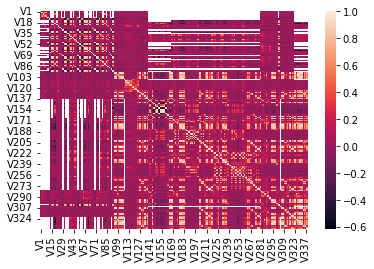

In [38]:
sns.heatmap(tv.corr())

In [22]:
# 같은 결측치 갯수의 group 확인 (15개)
nancount = list(tv.isnull().sum().value_counts().index)
tv.isnull().sum().value_counts()

460110    46
314       43
12        32
450909    31
76073     23
77096     22
89164     20
450721    19
168969    18
508595    18
508189    18
449124    16
279287    11
508589    11
1269      11
dtype: int64

In [23]:
# 각 그룹별로 isnull().sum(axis=1) 의 values 갯수가 2개 이상인 경우가 없음
# 결측치 갯수 별 그룹끼리, 행 단위로 결측치 여부가 같음

rowlen = list(tv.isnull().sum().value_counts().values)

for i in range(len(nancount)):
    if len(tv.loc[:,nan_group(i)].isnull().sum(axis=1).value_counts().index) != 2:
        print(nancount[i])
print('Done')

Done


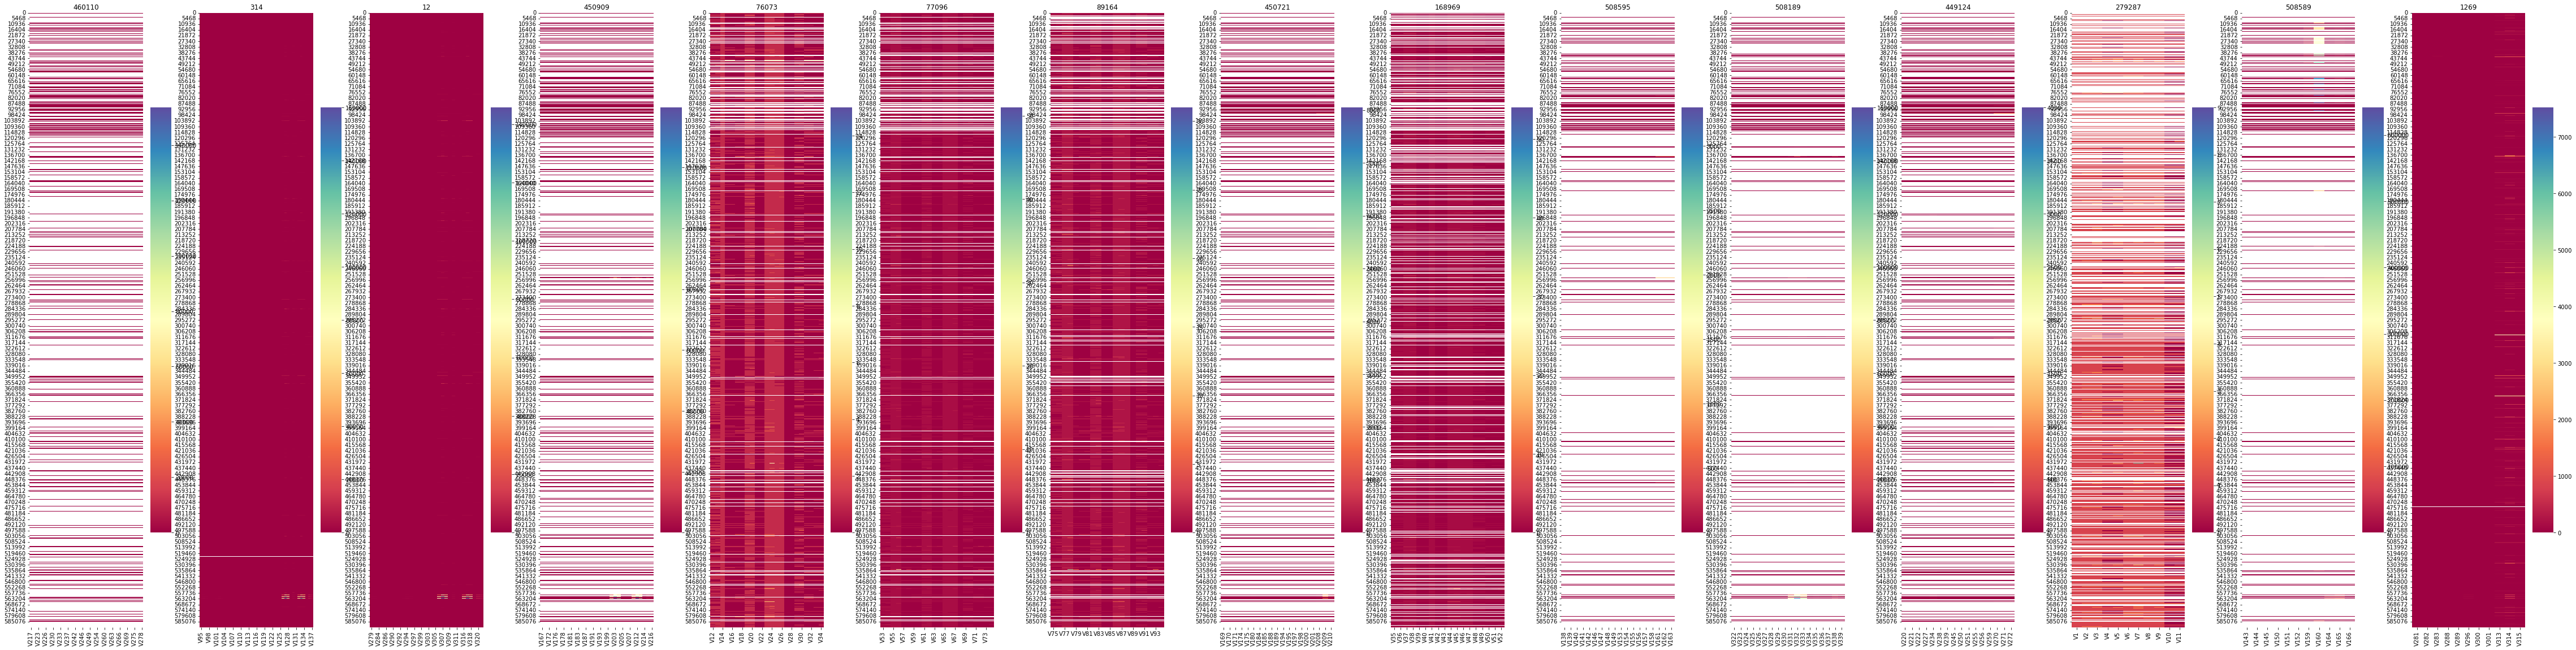

In [39]:
# 그룹별 패턴 시각화

fig, axes = plt.subplots(1,len(nancount), figsize=(80,20))

for i in range(len(nancount)):
    sns.heatmap(data=tv.loc[:, nan_group(i)], ax=axes[i],cmap="Spectral",cbar=False).set_title(nancount[i])

plt.show()

In [42]:
# 그룹별 분산 평균
temp = []
for i in nancount:
    temp.append(format(np.var(tv.loc[:,tv.isnull().sum() == i]).mean(), '.2f'))
pd.DataFrame(temp, index=nancount)

,0
460110,326869.75
314,1402989.56
12,1981192.91
450909,8098347.73
76073,0.13
77096,0.17
89164,0.21
450721,3890.93
168969,0.26
508595,680.43


In [64]:
# 각 그룹별 평균 분산도 확인
find_num = 1
temp = []
for i in nancount:
    temp.append(format(np.var(tv.loc[:,tv.isnull().sum() == i]).mean(), '.2f'))
pd.DataFrame(temp, index=nancount).astype('float64').style.applymap(draw_color_under, color='blue')

,0
460110,326869.750000
314,1402989.560000
12,1981192.910000
450909,8098347.730000
76073,0.130000
77096,0.170000
89164,0.210000
450721,3890.930000
168969,0.260000
508595,680.430000


<AxesSubplot:>

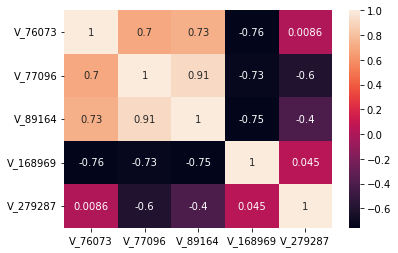

In [74]:
# 같은 결측치를 가진 컬럼들끼리 pca를 해서 각각의 컬럼으로 축소
# 그중에 평균 분산이 1이하인 위의 5개 분류만 활용. 총 5컬럼

ratio = pd.DataFrame(index = tv.index)

for i in nancount:
        if np.var(tv.loc[:,tv.isnull().sum() == i]).mean() < 1:
            T = tv.loc[:,tv.isnull().sum() == i].dropna(axis=0)
            temp_index = T.index
            Z = scaler.fit_transform(T)
            pca = PCA(n_components=1)
            ratio = ratio.merge(pd.DataFrame(pca.fit_transform(Z), columns=[f'V_{i}'],index = temp_index), how="left", on='TransactionID')
# 상관계수 확인
sns.heatmap(ratio.corr(), annot=True)

최종 V columns
- V_89164, V_168969, V_279287

##### User 특정화 ['uid']
- D columns
- card1
- P_emaildomain
- addr1
- ProductCD

In [133]:
# 278563 users
train_uid['uid'].value_counts()

-129.0_15775_nan330.0_S          1414
85.0_9500_aol.com126.0_W          406
159.0_8528_nan387.0_W             207
465.0_7207_nan204.0_W             189
202.0_12741_gmail.com143.0_W      156
                                 ... 
-22.0_10726_gmail.com337.0_W        1
226.0_17027_aol.com204.0_W          1
-48.0_3056_yahoo.com433.0_W         1
297.0_12435_gmail.com143.0_W        1
-182.0_12037_gmail.com231.0_W       1
Name: uid, Length: 278563, dtype: int64

In [201]:
train_uid = uid(train_t).loc[:,['isFraud','uid']]
train_uid.describe()

,isFraud
count,590540.000000
mean,0.034990
std,0.183755
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [230]:
# user화 했을 때 사기 유저와 비사기 유저로 구분 할 수 있다.
# 유저단위로 groupby.mean 해서, value가 0,1 이 아닌 오차율은 0.726 % 로 나타난다.
uid_group = train_uid.groupby('uid').mean().value_counts()
print(round(uid_group.iloc[2:-1].sum() / uid_group.iloc[0:2].sum() *100, 3),'%')

0.726 %


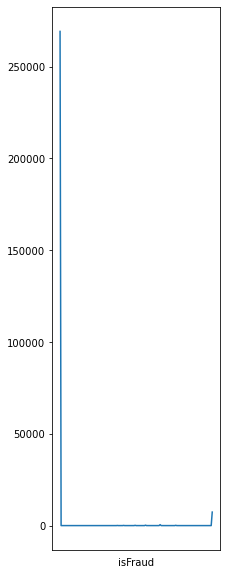

In [314]:
plt.figure(figsize=(3,10))
ax = uid_group.sort_index().reindex().plot()
plt.xticks([])
plt.show()

### Identity Table

In [356]:
print('identity의 데이터양은 transaction 대비\n train은',round(len(train_i) / len(train_t) * 100,3),'%\n test는',round(len(test_i) / len(test_t) * 100,3),'%')

identity의 데이터양은 transaction 대비
 train은 24.424 %
 test는 28.007 %


##### identity drop columns
- ['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_27', id_23', 'id_22']

In [330]:
top_missing_cols(test_m, thresh=0)

There are 414 columns in this dataset with missing values.
There are 414 columns with missing percent values than 0%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_08,99.127070
3,id_07,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


In [331]:
top_missing_cols(test_m, thresh=0)

There are 385 columns in this dataset with missing values.
There are 385 columns with missing percent values than 0%


,col,missing_percent
0,id-24,99.064519
1,id-25,99.005508
2,id-26,99.003929
3,id-21,99.001561
4,id-07,99.001561
5,id-08,99.001561
6,id-27,99.000969
7,id-23,99.000969
8,id-22,99.000969
9,dist2,92.809030


In [358]:
train_i.isnull().sum()

id_01              0
id_02           3361
id_03          77909
id_04          77909
id_05           7368
id_06           7368
id_07         139078
id_08         139078
id_09          69307
id_10          69307
id_11           3255
id_12              0
id_13          16913
id_14          64189
id_15           3248
id_16          14893
id_17           4864
id_18          99120
id_19           4915
id_20           4972
id_21         139074
id_22         139064
id_23         139064
id_24         139486
id_25         139101
id_26         139070
id_27         139064
id_28           3255
id_29           3255
id_30          66668
id_31           3951
id_32          66647
id_33          70944
id_34          66428
id_35           3248
id_36           3248
id_37           3248
id_38           3248
DeviceType      3423
DeviceInfo     25567
dtype: int64

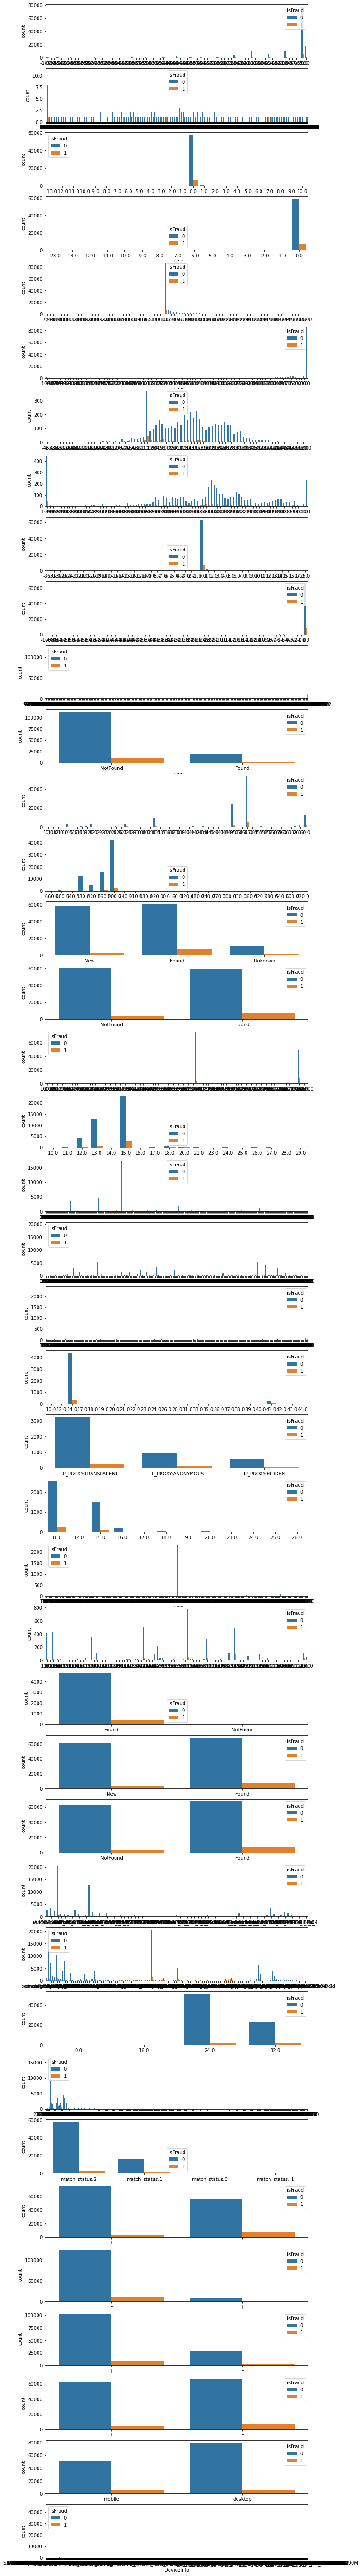

In [382]:
fig, axes = plt.subplots(len(train_i.columns),1,figsize=(10,100))
for i in list(train_i.columns):
    sns.countplot(data=train_m, x=i,hue='isFraud',ax=axes[list(train_i.columns).index(i)])
plt.show()

In [378]:
list(train_i.columns).index('id_01')

0